In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.


# Temperature forecasting with Probabilistic LSTM


This notebook showcase the probabilistic LSTM forecaster of [Timeseria](https://github.com/sarusso/Timeseria).

Let's start by loading an example time series, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'temperature.csv').resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 18331 DataTimePoints in 3189 DataTimePoints


Have a look at the time series we just loaded:

In [3]:
timeseries

Time series of #3189 points at 1h resolution, from point @ 1546480800.0 (2019-01-03 02:00:00+00:00) to point @ 1557957600.0 (2019-05-15 22:00:00+00:00)

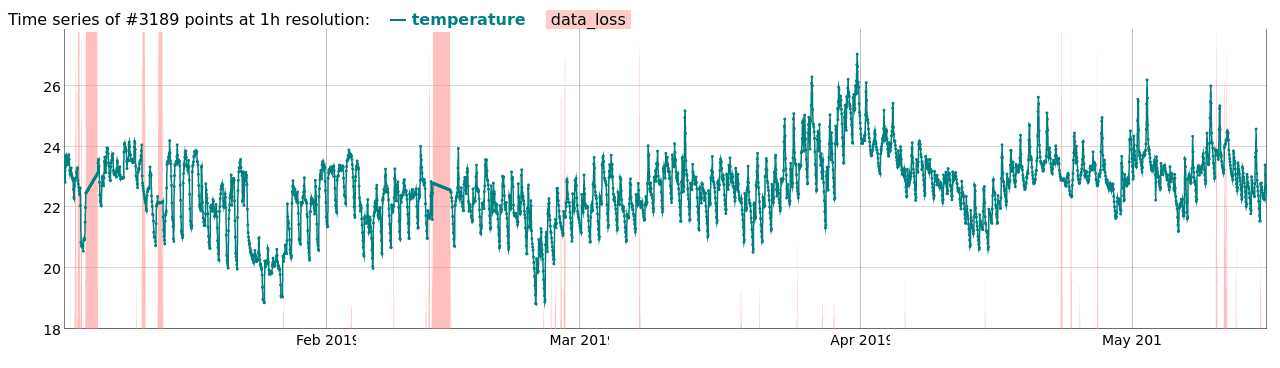

In [4]:
timeseries.plot()

Instantiate and fit the model:

In [5]:
from timeseria.models import LSTMForecaster

forecaster = LSTMForecaster(window=24, features=['values', 'hours'])
forecaster.fit(timeseries, validation_split=0.2, reproducible=True, probabilistic=True)

Call the `predict()` function of the model. This returns key-value data with the prediction values:

In [6]:
forecaster.predict(timeseries)

{'temperature': 22.314860736080703}

In this case, the predicitons are probabilistic:

In [7]:
type(forecaster.predict(timeseries)['temperature'])

timeseria.utils.PFloat

The PFloat (probabilistic float) class behaves as a standard float but with extra features, as the information about the distribution:

In [8]:
forecaster.predict(timeseries)['temperature'].dist

{'type': 'gennorm',
 'params': {'beta': 2.5597347643477777,
  'loc': 22.309729639894833,
  'scale': 0.2993567342568525},
 'pvalue': 0.3579384114701361}

PFloats can even be plotted, possibly together with the original data (if provided at creation-time):

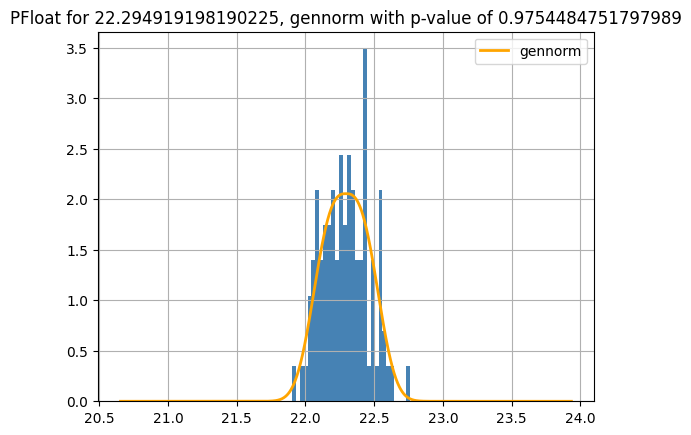

In [9]:
forecaster.predict(timeseries)['temperature'].plot()

PFloat objects are automatically handled by the plotting engine, so so that the time series resulting from an `apply()` call is plotted together with its probability intervals (by default, from 5% to 95%):

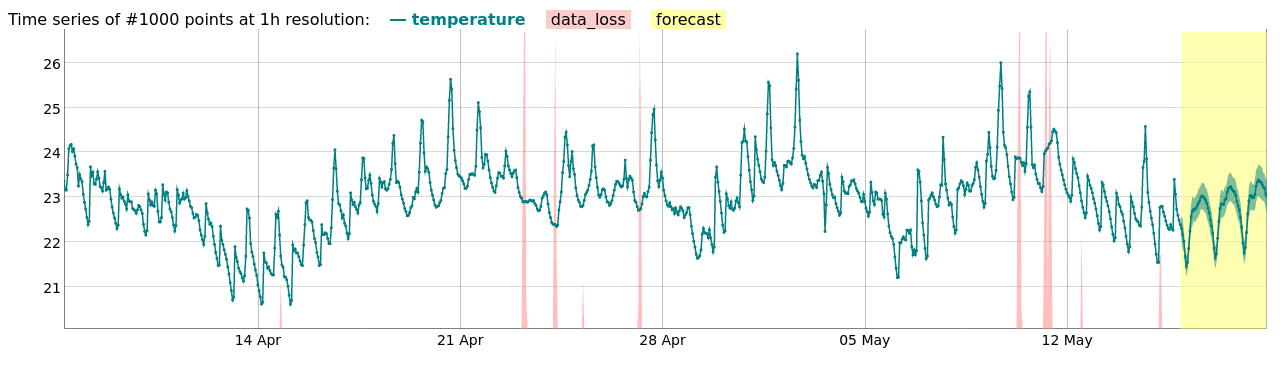

In [10]:
forecaster.apply(timeseries, steps=24*3)[-1000:].plot()

Custom probabilty intervals can be set with the ``probability_interval`` extra argument (e.g ``probability_interval = [0.01, 0.99]``, and should be required, probabilistic plotting can be entirely disabled with by setting ``probabilistic=False``.

When evaluating a forecaster that supports probabilisitc predictions, also confidence metrics are computed. By default, the Empirical Coverage (EC), which is obtained using the default confidence interval of 0.05 - 0.095, and that, if the model is well-calibrated, should provide a number close to 0.90.

Other confidence metrics can be evaluated as well, for now only the Empirical Coverage Error (EC) and Empirical Coverage Percentage Error (ECPE), and also a different confidence interval to use for the evaluation can be set.

Lastly, if returning the evaluation series, this will include the probabilistic predictions, allowing to easily inspect them, as in the exmaple below, which includes also some of the abovementioned options:

In [11]:
evaluation = forecaster.evaluate(timeseries[300:900],
                                 confidence_metrics=['EC', 'ECE', 'ECPE'],
                                 confidence_interval=[0.05,0.95],
                                 return_evaluation_series=True,
                                 verbose=True)

Evaluating for "temperature": .........


In [12]:
evaluation

{'temperature_RMSE': 0.3365137703333537,
 'temperature_MAE': 0.24680704787219682,
 'temperature_EC': 0.6354166666666666,
 'temperature_ECE': 0.2645833333333333,
 'temperature_ECPE': 0.2939814814814814,
 'series': Time series of #576 points at 1h resolution, from point @ 1547647200.0 (2019-01-16 14:00:00+00:00) to point @ 1549717200.0 (2019-02-09 13:00:00+00:00)}

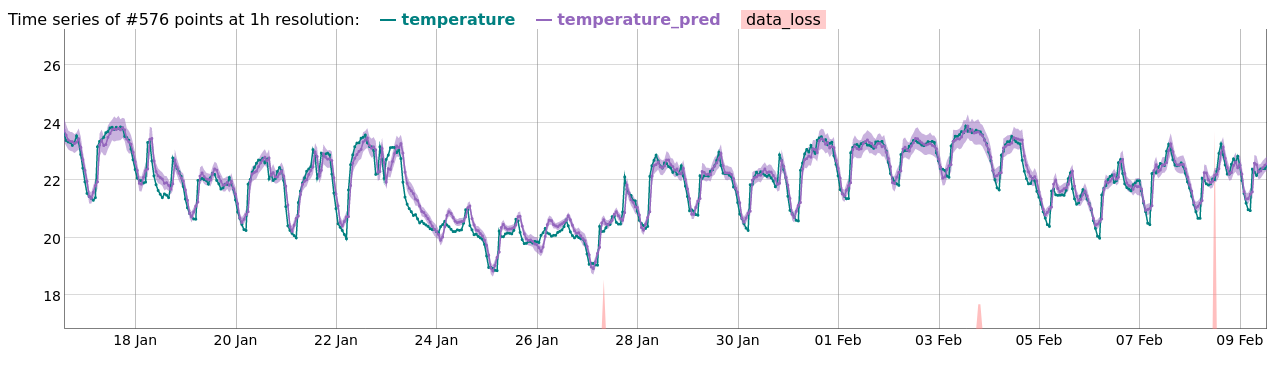

In [13]:
evaluation['series'].plot(data_labels=['temperature', 'temperature_pred'], value_range=[17,27])